# Experiment: UMAP by Condition
Generate a UMAP plot for one selected condition, comparing `Truth` vs `Pred`.
Update `selected_condition` in the config cell and run the final cell.


In [1]:
from pathlib import Path
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

try:
    import umap
except ImportError as exc:
    raise SystemExit("Missing dependency: umap-learn. Install with `pip install umap-learn`.") from exc

repo_root = Path.cwd()
if not (repo_root / "scripts").exists() and (repo_root.parent / "scripts").exists():
    repo_root = repo_root.parent


def _safe_name(text: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", text).strip("_")


def _equal_sample_pair(pred: np.ndarray, truth: np.ndarray, seed: int) -> tuple[np.ndarray, np.ndarray]:
    if pred.ndim != 2 or truth.ndim != 2:
        raise ValueError("pred/truth must be 2D arrays")
    if pred.shape[1] != truth.shape[1]:
        raise ValueError("pred/truth feature dims mismatch")

    n = min(pred.shape[0], truth.shape[0])
    if n <= 0:
        return pred[:0], truth[:0]
    if pred.shape[0] == n and truth.shape[0] == n:
        return pred, truth

    rng = np.random.default_rng(seed)
    pred_idx = rng.choice(pred.shape[0], size=n, replace=False) if pred.shape[0] > n else np.arange(n)
    truth_idx = rng.choice(truth.shape[0], size=n, replace=False) if truth.shape[0] > n else np.arange(n)
    return pred[pred_idx], truth[truth_idx]


def plot_umap_one_condition(
    cond: str,
    pred: np.ndarray,
    truth: np.ndarray,
    out_path: Path,
    seed: int,
    equal_sample: bool = True,
) -> None:
    if pred.ndim != 2 or truth.ndim != 2:
        raise ValueError(f"{cond}: pred/truth must be 2D arrays")
    if pred.shape[1] != truth.shape[1]:
        raise ValueError(f"{cond}: pred/truth feature dims mismatch")
    if pred.shape[1] == 0:
        raise ValueError(f"{cond}: empty DE feature matrix")

    if equal_sample:
        pred, truth = _equal_sample_pair(pred, truth, seed)
        if pred.shape[0] == 0:
            raise ValueError(f"{cond}: no samples after equal sampling")

    x = np.vstack([truth, pred]).astype(np.float32, copy=False)
    labels = np.array(["Truth"] * truth.shape[0] + ["Pred"] * pred.shape[0], dtype=object)

    if x.shape[0] < 3:
        raise ValueError(f"{cond}: too few samples for UMAP")

    n_neighbors = max(2, min(15, x.shape[0] - 1))
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=0.3,
        random_state=seed,
    )
    emb = reducer.fit_transform(x)

    truth_mask = labels == "Truth"
    pred_mask = labels == "Pred"

    plt.figure(figsize=(7, 5))
    plt.scatter(emb[truth_mask, 0], emb[truth_mask, 1], s=20, alpha=0.75, label=f"Truth (n={truth.shape[0]})")
    plt.scatter(emb[pred_mask, 0], emb[pred_mask, 1], s=20, alpha=0.75, label=f"Pred (n={pred.shape[0]})")
    plt.title(f"{cond} | UMAP on DE features ({pred.shape[1]} genes)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(alpha=0.25)
    plt.legend()
    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=160)
    plt.close()


d:\conda_envs\scouter\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
pkl_path = repo_root / "artifacts" / "results" / "adamson" / "trishift_adamson_1.pkl"
out_dir = repo_root / "artifacts" / "results" / "adamson" / "umap_plots"
selected_condition = "AARS+ctrl"  # Change to your target condition
seed = 24
equal_sample = True  # Sample Truth/Pred to equal counts


In [3]:
import pickle

with pkl_path.open("rb") as f:
    obj = pickle.load(f)

conditions = sorted(obj.keys())
print(f"Total conditions: {len(conditions)}")
print("First 10:", conditions[:10])
if selected_condition not in obj:
    raise ValueError(f"Condition not found: {selected_condition}")
        


Total conditions: 17
First 10: [np.str_('AARS+ctrl'), np.str_('AMIGO3+ctrl'), np.str_('ATP5B+ctrl'), np.str_('CCND3+ctrl'), np.str_('DDRGK1+ctrl'), np.str_('EIF2B4+ctrl'), np.str_('HSPA9+ctrl'), np.str_('HYOU1+ctrl'), np.str_('IDH3A+ctrl'), np.str_('IER3IP1+ctrl')]


d:\conda_envs\scouter\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: e:\CODE\trishift\artifacts\results\adamson\umap_plots\AARS_ctrl_umap.png


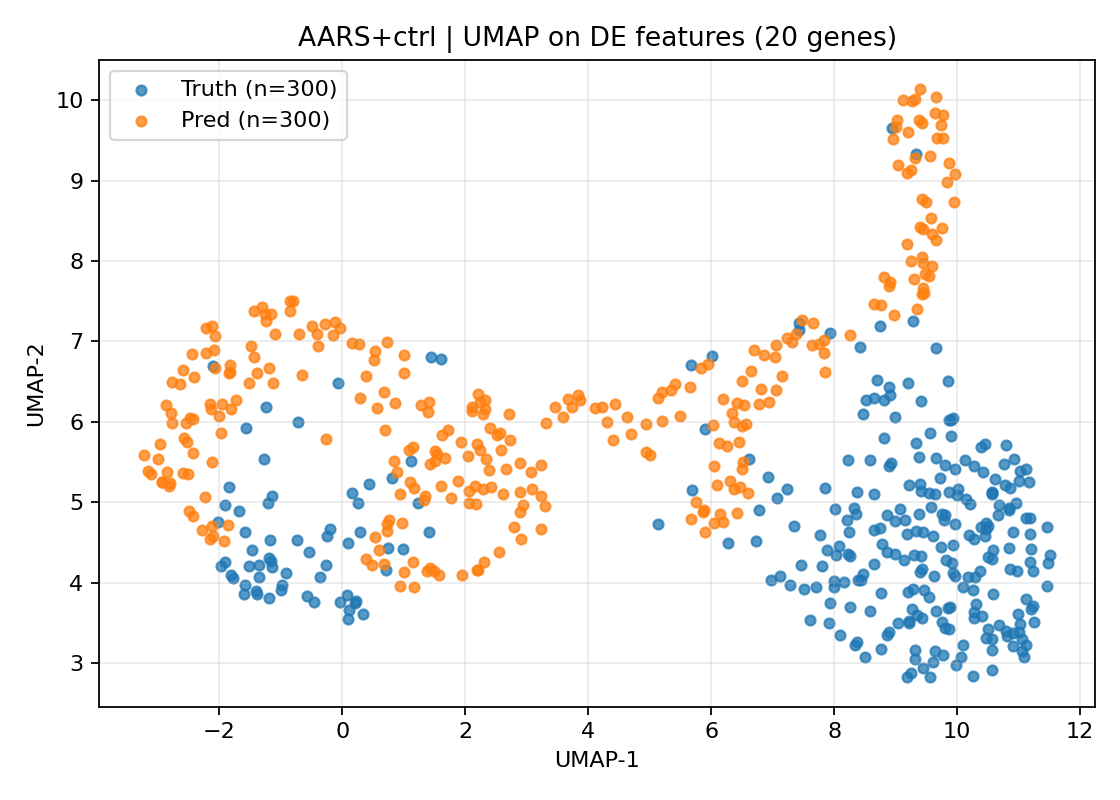

In [4]:
item = obj[selected_condition]
pred = np.asarray(item.get("Pred", np.empty((0, 0), dtype=np.float32)))
truth = np.asarray(item.get("Truth", np.empty((0, 0), dtype=np.float32)))

img_path = out_dir / f"{_safe_name(selected_condition)}_umap.png"
plot_umap_one_condition(
    cond=selected_condition,
    pred=pred,
    truth=truth,
    out_path=img_path,
    seed=seed,
    equal_sample=equal_sample,
)
print("Saved:", img_path)
display(Image(filename=str(img_path)))
